# Anomalous trends with clustering

In [1]:
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


from astroExplain.spectra import clustering
from sdss.metadata import MetaData

meta = MetaData()

# Custom functions

## averages in clusters

In [16]:
def plot_averages_clusters(
    spectra_cluster_dict,
    weights_cluster_dict,
    wave,
):

    n_clusters = len(spectra_cluster_dict)

    fig, axs = plt.subplots(
        nrows=n_clusters,
        ncols=2,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    #  weights of centroid

    for label, cluster_weights in weights_cluster_dict.items():

        avg_weights = cluster_weights.mean(axis=0)
        avg_weights /= np.max(avg_weights)

        avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

        axs[label, 0].plot(
            wave, avg_spectrum,
            color="black",
        )
        # weights
        axs[label, 1].plot(
            wave, avg_weights,
            color="black",
            label=f"Cluster {label}"
        )

        axs[label, 1].legend(
            [f"Cluster {label}"],
            fontsize=6,
            handlelength=0, handletextpad=0,
            loc="upper right",
            frameon=False
        )
        # set limits
        axs[label, 1].set_ylim(0, 1.1)

    axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
    axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")

    return fig, axs

<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:51: SyntaxWarning: invalid escape sequence '\l'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_259417/3553967644.py:51: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_259417/3553967644.py:52: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")


## Centroids

In [29]:
def plot_centroids(
    spectra_cluster_dict,
    centroids,
    wave,
    n_segments=128,
):

    n_clusters = len(spectra_cluster_dict)

    fig, axs = plt.subplots(
        nrows=n_clusters,
        ncols=2,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    #  weights of centroid

    for label, centroid in enumerate(centroids):

        centroid = clustering.expand_weights_per_segments(
            centroid.reshape(1, -1),
            wave.size,
            n_segments,
        )

        centroid /= np.max(centroid)
        centroid = centroid.reshape(-1)
        avg_spectrum = spectra_cluster_dict[label].mean(axis=0)

        axs[label, 0].plot(
            wave, avg_spectrum,
            color="black",
        )
        # weights
        axs[label, 1].plot(
            wave, centroid,
            color="black",
            label=f"Cluster {label}"
        )

        axs[label, 1].legend(
            [f"Cluster {label}"],
            fontsize=6,
            handlelength=0, handletextpad=0,
            loc="upper right",
            frameon=False
        )
        # set limits
        axs[label, 1].set_ylim(0, 1.1)

    axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
    axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")

    return fig, axs

<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
<>:57: SyntaxWarning: invalid escape sequence '\l'
<>:58: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_259417/3233836559.py:57: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,0].set_xlabel("$\lambda$ [$\AA$]")
/tmp/ipykernel_259417/3233836559.py:58: SyntaxWarning: invalid escape sequence '\l'
  axs[n_clusters - 1,1].set_xlabel("$\lambda$ [$\AA$]")


In [38]:
def plot_single_centroid(
    centroid, avg_spectrum,
    wave,
    n_segments=128,
):

    centroid = clustering.expand_weights_per_segments(
        centroid.reshape(1, -1),
        wave.size,
        n_segments,
    )

    centroid /= np.max(centroid)
    centroid = centroid.reshape(-1)

    fig, axs = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=None,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    # set minor ticks on
    for ax in axs.flatten(): ax.minorticks_on()

    axs[0].plot(
        wave, avg_spectrum,
        color="black",
    )
    # weights
    axs[1].plot(
        wave, centroid,
        color="black",
    )

    # set limits
    axs[1].set_ylim(0, 1.1)
    axs[1].set_xlabel("$\lambda$ [$\AA$]")
    axs[0].set_ylabel("Normalized flux")
    axs[1].set_ylabel("Normalized weights (MAX)")

    return fig, axs

<>:40: SyntaxWarning: invalid escape sequence '\l'
<>:40: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_259417/3278944214.py:40: SyntaxWarning: invalid escape sequence '\l'
  axs[1].set_xlabel("$\lambda$ [$\AA$]")


# Data ingestion

In [3]:
bin_id = "bin_03"
phd_dir = "/home/elom/phd"
spectra_dir = f"{phd_dir}/00_phd_code/spectra"
explanations_dir = f"{phd_dir}/00_phd_code/explanations"
paper_figures_dir = f"{phd_dir}/00_paper_explain-me-why/sections/figures/"
wave = np.load(f"{spectra_dir}/wave_spectra_imputed.npy")


# MSE
From previous analysis we determined the number of clusters is 6
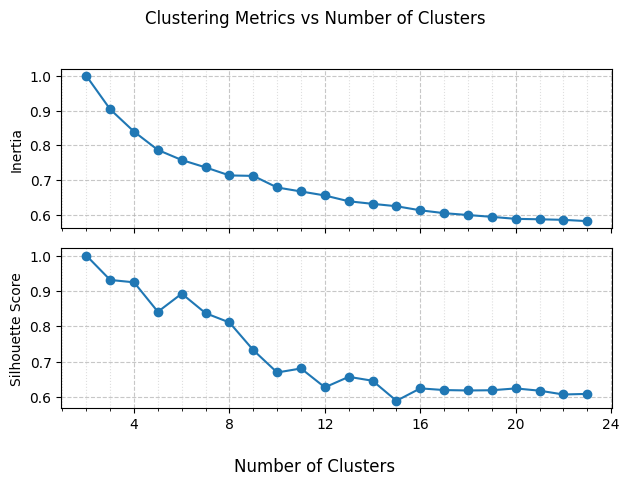

In [5]:
score_dict = {
    "metric": "mse_noRel100",
    "run_id": "20250427190650_uniform_5000_scale",
    "weights": None,
    "norm_weights": None,
    "unique_weights": None,
    "norm_unique_weights": None,
    "anomalies": None,
    "anomalies_df": None,
}

score_dict["weights"] = np.load(
    f"{explanations_dir}/{bin_id}/"
    f"{score_dict['metric']}/weights_{score_dict['run_id']}.npy"
)

score_dict["norm_weights"] = clustering.normalize_weights_l2_abs(
    score_dict["weights"]
)

score_dict["unique_weights"] = clustering.compress_weights_per_segments(
    weights=score_dict["weights"],
    n_segments=128
)
score_dict["norm_unique_weights"] = clustering.normalize_weights_l2_abs(
    score_dict["unique_weights"]
)


score_dict["anomalies"] = np.load(
    f"{spectra_dir}/{bin_id}/{score_dict['metric']}/top_anomalies.npy",
    mmap_mode="r"
)

score_dict["anomalies_df"] = pd.read_csv(
    f"{spectra_dir}/{bin_id}/{score_dict['metric']}/top_anomalies.csv.gz",
    index_col="specobjid",
)

Base size: 29, Residual size: 61
New number of segments: 129


## Cluster unique explanation weights

In [18]:
n_clusters = 6

start_time = time.perf_counter()

kmeans = KMeans(
    n_clusters=n_clusters, random_state=0
).fit(score_dict["norm_unique_weights"])

end_time = time.perf_counter()
print(f"train time: {end_time - start_time:.2f} seconds")

cluster_labels = kmeans.labels_

# get spectra and weights per cluster
(
    spectra_cluster_dict, weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"],
    weights=score_dict["norm_weights"],
    print_n_clusters=True
)

(
    _, unique_weights_cluster_dict
) = clustering.group_spectra_by_cluster(
    cluster_labels=cluster_labels,
    anomalies_array=score_dict["anomalies"],
    weights=score_dict["norm_unique_weights"],
    print_n_clusters=False
)

centroids = kmeans.cluster_centers_


train time: 0.19 seconds
Cluster: 0,N. spectra: 1085
Cluster: 1,N. spectra: 2769
Cluster: 2,N. spectra: 1501
Cluster: 3,N. spectra: 2967
Cluster: 4,N. spectra: 1465
Cluster: 5,N. spectra: 213


## Average spectrun and explantions

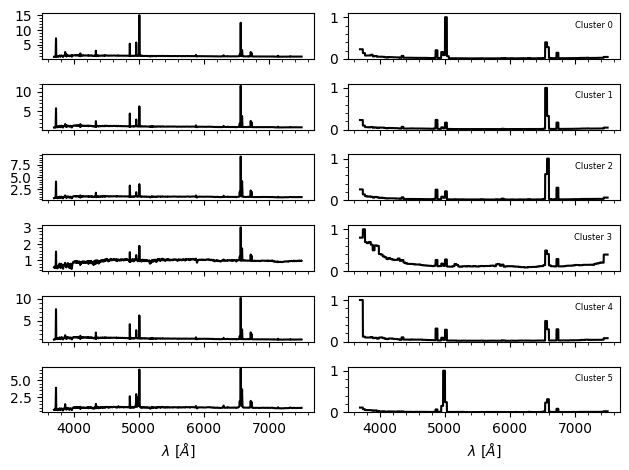

In [20]:
fig, axs = plot_averages_clusters(
    spectra_cluster_dict=spectra_cluster_dict,
    weights_cluster_dict=weights_cluster_dict,
    wave=wave,
)


## Centroids

Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129
Base size: 29, Residual size: 61
New number of segments: 129


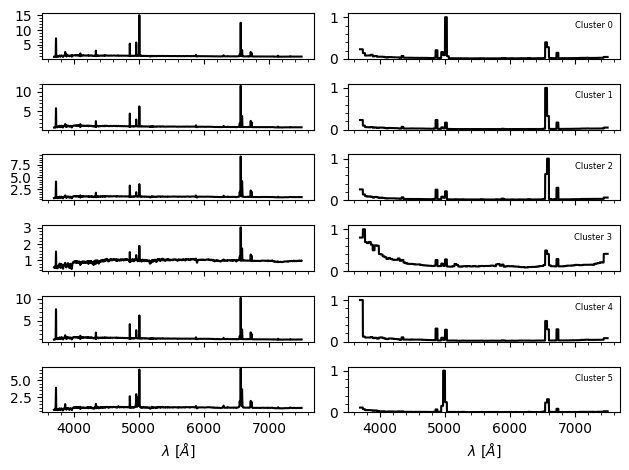

In [30]:
centroids = kmeans.cluster_centers_
fig, axs = plot_centroids(
    spectra_cluster_dict=spectra_cluster_dict,
    centroids=centroids,
    wave=wave,
    n_segments=128,
)

## Single centroids

Base size: 29, Residual size: 61
New number of segments: 129


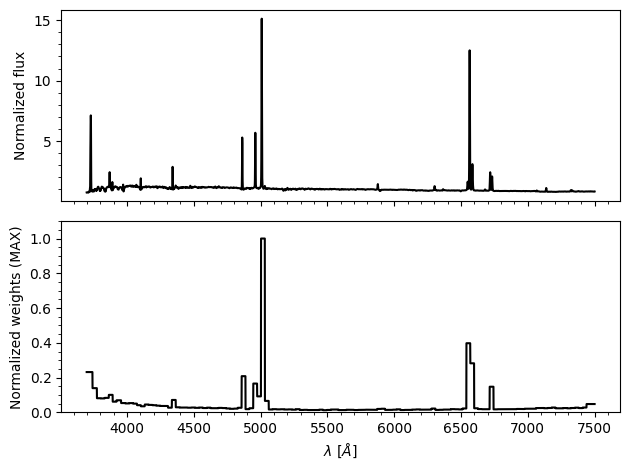

In [39]:
cluster_label = 0
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


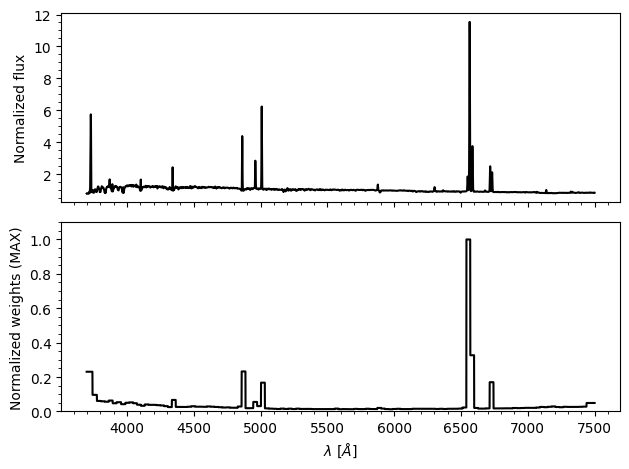

In [40]:
cluster_label = 1
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


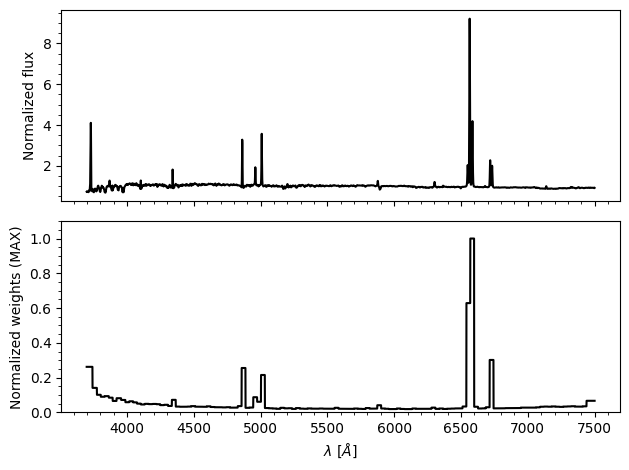

In [41]:
cluster_label = 2
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


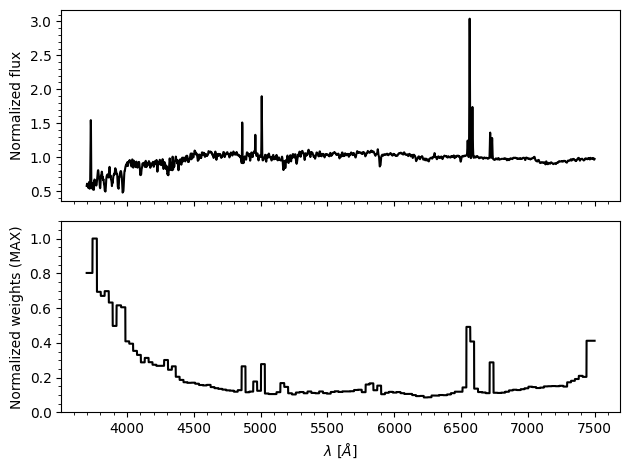

In [42]:
cluster_label = 3
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


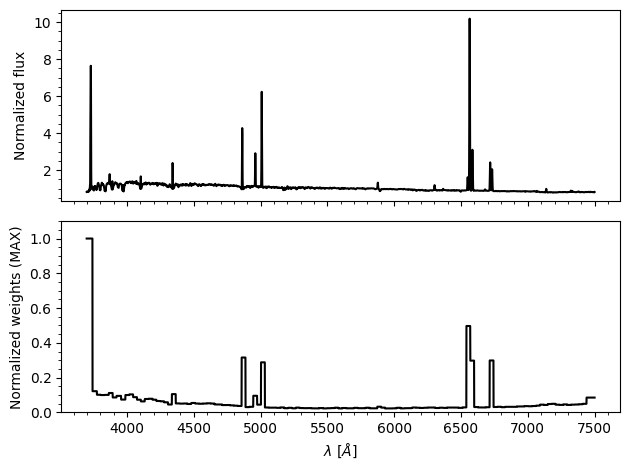

In [43]:
cluster_label = 4
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

Base size: 29, Residual size: 61
New number of segments: 129


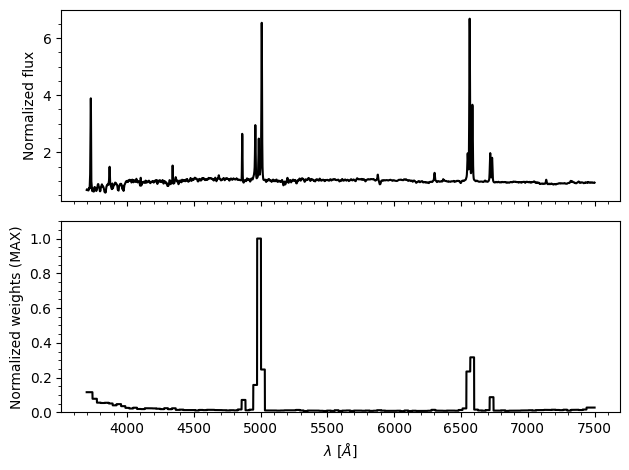

In [44]:
cluster_label = 5
fig, axs = plot_single_centroid(
    centroid=centroids[cluster_label],
    avg_spectrum=spectra_cluster_dict[cluster_label].mean(axis=0),
    wave=wave,
    n_segments=128,
)

# MSE filter 250 kms noRel97

# MSE filter 250 kms noRel100

# MSE filter 250 kms noRel97